In [1]:
import os, time, itertools
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from scipy import sparse
from scipy.sparse.linalg import inv
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler import transpile, assemble
from qiskit.quantum_info import DensityMatrix
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
from operators.pauli_hamiltonian import PauliHamiltonian
from quantum_circuit.trotterization import trotter_electric, trotter_coupling, trotter_plaquette
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from utils.matrix_operations import *
from utils.circuits import *
from quantum_info.expectation import expectation
from quantum_info.mitigation_gate import noise_mitigation_gate

In [2]:
sig = []
sig.append(np.eye(2))
sig.append(np.array([[0, 1], [1, 0]]))
sig.append(np.array([[0, -1j], [1j, 0]]))
sig.append(np.array([[1, 0], [0, -1]]))

In [14]:
# 2 triangle plaquettes
T = 1
n_steps = 10
g = 0.5
alpha = 1
n_layers = 2
coef_doubler = 2 if n_layers == 2 else 1
H = TrianglePlaquetteHamiltonian(g, alpha, n_layers)

In [4]:
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s 
    

In [5]:
backend = Aer.get_backend('qasm_simulator')

In [7]:
# Load IBMQ account
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='bnl', project='hep129')
print(provider.backends())
#device_backend = provider.get_backend('ibmq_16_melbourne')
device_backend = provider.get_backend('ibmq_johannesburg')
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates
device_backend

Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>]
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>, <IBMQBackend('ibmq_rochester') fr

<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='bnl', project='hep129')>

In [36]:
def physical_trotter_plaquette(circ, target_indices, coef, deltaT):
    """
    Trotter step for one plaquette term
    S^+ otimes S^+ otimes S^+ + h.c.
    
    Assume the lattice structure is 0 - 1 - 2
    
    
    Arguments:
    circ: qiskit.QuantumCircuit, the target circuit
    qr: qiskit.QunatumRegister, the input qubit state
    target_inidices: list of int, the target indices of the plaquette
    coef: float, coefficient corresponding to the plaquette term
    deltaT: small time step
    Return:
    qiskit.QuantumCircuit, the circuit after added the trotterization step.
    """ 
    assert(len(target_indices)==3), "List of target indices for a plaquette term with invalid length is given."
    # Add cnot gates to target qubits
    for i in range(2):
        circ.cx(target_indices[i+1], target_indices[i])
        circ.u3(np.pi, 0, np.pi, target_indices[i])    
    # Add CCRX gate
    circ = add_crx(circ, coef*deltaT/2, target_indices[1], target_indices[2])
    circ.cx(target_indices[0], target_indices[1])
    circ = add_crx(circ, -coef*deltaT/2, target_indices[1], target_indices[2])
    circ.cx(target_indices[0], target_indices[1])
    circ = add_swap(circ, target_indices[0], target_indices[1]) # Swap 0 and 1
    circ = add_crx(circ, coef*deltaT/2, target_indices[1], target_indices[2])
    circ = add_swap(circ, target_indices[0], target_indices[1]) # Swap back
    
    # Add cnot gates to target qubits
    for i in range(2)[::-1]:
        circ.u3(np.pi, 0, np.pi, target_indices[i])
        circ.cx(target_indices[i+1], target_indices[i])
    
    return circ

def physical_trotter_circ(circ, target_indices, g, alpha, T, n_steps, add_gt = False, unitary_sim = False):
    """
    For a device with the lattice substructure of six qubits as
    0 - 3 - 1
    |       |
    2 - 5 - 4
    (the indices are those of target_indices)
    
    E, XY interactions between 0-3, 1-4, 2-5
    SWAP 1 and 3
    Plaquette interactions between 2-0-3, 5-4-1 
    Arguments:
    circ: qiskit.QuantumCircuit, the target circuit
    target_inidices: list of int, the target indices of qubits. target_indices[logical_q] = physical_qr
    g: float, the value of g
    alpha: float, the value of alpha
    T: float, the evolution time
    n_steps: int, the number of Trotter steps
    mitigation_dict: dict, dictionary specifying the pauli gate for mitigation. E.g. {'0E03' : 'XY', '1XY14': 'YZ', 1B012': 'ZXX'} the first integer specifies the target step
    
    """
    deltaT = T/n_steps
    def add_gauge_rotation():
        for i in range(3):
            for s in range(2):
                circ.u1(ts[i] - ts[i-1], target_indices[i+s*3])
                circ.u3(np.pi, 0, np.pi, target_indices[i+s*3])
                circ.u1(-ts[i] + ts[i-1], target_indices[i+s*3])
                circ.u3(np.pi, 0, np.pi, target_indices[i+s*3])
    for stp in range(n_steps):
        for j in range(3):
            circ = trotter_electric(circ, [target_indices[j], target_indices[j+3]], 2*g**2/2, deltaT, unitary_sim, further_opt=True)
            if add_gt:
                add_gauge_rotation()
                
            circ = trotter_coupling(circ, [target_indices[j+3], target_indices[j]], 2*alpha/(2*g**2), deltaT, further_opt=True)
            if add_gt:
                add_gauge_rotation()
    
        circ = add_swap(circ, target_indices[1], target_indices[3]) # Swap 1 and 3
                
        circ = physical_trotter_plaquette(circ, [target_indices[2], target_indices[0], target_indices[3]], -1/(2*g**2), deltaT)
                
        circ = physical_trotter_plaquette(circ, [target_indices[5], target_indices[4], target_indices[1]], -1/(2*g**2), deltaT)
                
        circ = add_swap(circ, target_indices[1], target_indices[3]) # Swap back
        if add_gt:
                add_gauge_rotation()

    return circ
    

# Circuit Components

In [9]:
def electric_circ(circ, input_mapping, unitary_sim = False):
    circ = trotter_electric(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*g**2/2, deltaT=T/n_steps, unitary_sim=unitary_sim, further_opt = True)
    return circ

def coupling_circ(circ, input_mapping, unitary_sim = False):
    circ = trotter_coupling(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*alpha/(2*g**2), deltaT=T/n_steps, further_opt = True)
    return circ

def exy_circ(circ, input_mapping, unitary_sim = False):
    circ = trotter_electric(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*g**2/2, deltaT=T/n_steps, unitary_sim=unitary_sim, further_opt = True)
    circ = trotter_coupling(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*alpha/(2*g**2), deltaT=T/n_steps, further_opt = True)
    return circ

def plaquette_circ(circ, input_mapping, unitary_sim = False):
    circ = physical_trotter_plaquette(circ=circ, target_indices=input_mapping, coef=-1/(2*g**2), deltaT=T/n_steps)
    return circ

def trotter_circ(circ, input_mapping, unitary_sim = False):
    circ = physical_trotter_circ(circ, input_mapping, g, alpha, 0.1, 1, {}, unitary_sim = False)
    return circ

# Exact

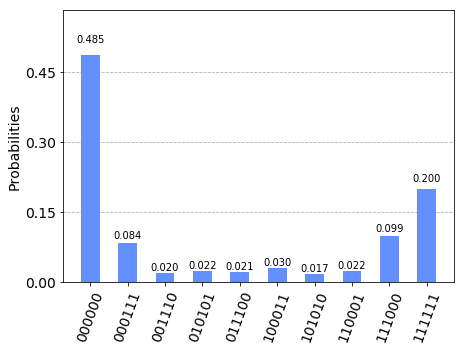

In [25]:
circ = QuantumCircuit(6, 6)
physical_trotter_circ(circ, list(range(6)), g, alpha, T, n_steps, unitary_sim = False)
circ.measure(list(range(6)), list(range(6)))
result = execute(circ, backend).result()
plot_histogram(result.get_counts(0))

# No mitigation

In [40]:
n_experiments = 1
job_manager = IBMQJobManager()
circ = QuantumCircuit(device_backend.configuration().n_qubits, 6)
physical_trotter_circ(circ, [5, 7, 10, 6, 12, 11], g, alpha, 0.1, 1, unitary_sim = False)
circ.measure([5, 7, 10, 6, 12, 11], list(range(6)))
jobs = job_manager.run([circ]*n_experiments, backend=device_backend)
print(jobs.report())
while any(stat != JobStatus.DONE for stat in jobs.statuses()):
    time.sleep(60)
results = jobs.results()
print(jobs.error_messages())
dist_nomit = {dec_to_binary_str(i, 6): 0. for i in range(2**6)}
for i in range(n_experiments):
    counts = results.get_counts(i)
    for key in counts.keys():
        dist_nomit[key] += counts[key]

Job set name: 2020-07-23T13:15:00.451594
          ID: 91c71ad70267411a953d3dd246ae493d-15955101004515946
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-0
    job index: 0
    status: job is being initialized
None


<a list of 64 Text xticklabel objects>


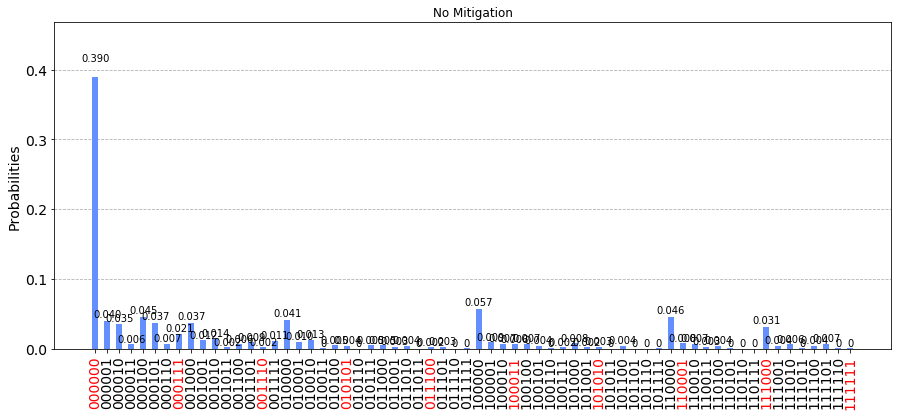

In [41]:
counts_nomit = {dec_to_binary_str(i, 6): dist_nomit.get(dec_to_binary_str(i, 6), 0) for i in range(2**6)}
fig, ax = plt.subplots(figsize=(15, 6))
#ax.bar(counts_nomit.keys(), [v for v in counts_nomit.values()])
xlabels = list(counts_nomit.keys())
plot_histogram(dist_nomit, ax=ax, title="No Mitigation")
ax.set_xticklabels(xlabels, rotation=90)
[ax.get_xticklabels()[i].set_color("red") for i in range(64) if i%7 == 0]
print(ax.get_xticklabels())
plt.show()

In [17]:
expectation(counts_nomit, 1024)

0.037109375

# With Mitigation

## Mitigate errors by gauge rotations
The state after real-time evolution must be physical, i.e. it must be in the Gauss's law sector.  
Let $G_a$ be the gauge generator acting on the site $a$ in the spatial dimensions. Then, for a physical state $|\psi\rangle$ and a unphysical state $\phi\rangle$, 
\begin{equation}
G_a |\psi\rangle = 0 \thinspace \forall a, \qquad G_a |\phi\rangle = g_a \neq 0 \thinspace \exists a
\end{equation}
Suppose a noisy unitary operation can be decomposed as $U_{noisy} = \Gamma_\epsilon\circ U$. The noise $\Gamma_\epsilon$ let the state leaks out of the physical sector as
\begin{equation}
\Gamma_\epsilon \sum_{i=1}^m a_i |\psi_i\rangle = (1-\epsilon)\sum_{i=1}^m a_i |\psi_i\rangle + \epsilon\sum_{j=1}^{2^N-m} b_j |\phi_j\rangle
\end{equation}
where $|\psi_i\rangle$ are physical states and $|\phi_j\rangle$ are unphysical states.  
The gauge transformation $e^{\large i \theta G_a}$ gives no phase to the physical states, but the unphysical states obtain some phase $e^{\large i \theta g_{a, j}}$.  
So, if one applies the gauge rotation after each trotter step with a random $\theta$ obtained from some distribution that covers the $S^1$ manifold uniformly, one can expect that the phases will be cancelled (up to $O(\epsilon^2)$), and hence the unphysical states will be vanished.  
  
The generators of $U(1)$ gauge transformations are defined as
\begin{equation}
G_a = \sum_s \sum_{j \in \star_{a, s}} (-1)^j \sigma^z_j
\end{equation}
The gauge rotation is
\begin{equation}
e^{\large i \theta G_a} = e^{\large i \theta \sum_s \sum_{j \in \star_{a, s}} (-1)^j \sigma^z_j} = \prod_s \prod_{j \in \star_{a, s}} e^{\large i (-1)^j \theta \sigma^z_j}
\end{equation}
since each term in the gauge generator commutes with each other. So, the gauge transformation can be realized on a quantum circuit as one-qubit Z-rotation gates with the angle $(-1)^j \theta$ on the corresponding qubits. 

Job set name: 2020-07-23T13:09:28.378457
          ID: f534fd0d3ac54215a22726b158e05703-15955097683784575
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-0
    job index: 0
    status: job is being initialized
None


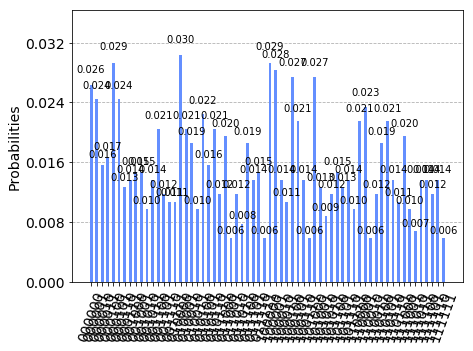

In [38]:
n_experiments = 1
job_manager = IBMQJobManager()
circ = QuantumCircuit(device_backend.configuration().n_qubits, 6)
target_ind = [5, 7, 10, 6, 12, 11]
physical_trotter_circ(circ, [5, 7, 10, 6, 12, 11], g, alpha, T, n_steps, add_gt = True, unitary_sim = False)
"""
for stp in range(n_steps):
    physical_trotter_circ(circ, [5, 7, 10, 6, 12, 11], g, alpha, T/n_steps, 1, unitary_sim = False)
    
    # Add gauge rotations
    ts = np.random.uniform(low=0.0, high=2*np.pi, size=3)
    
    for i in range(3):
        for s in range(2):
            circ.u1(ts[i] - ts[i-1], target_ind[i+s*3])
            circ.u3(np.pi, 0, np.pi, target_ind[i+s*3])
            circ.u1(-ts[i] + ts[i-1], target_ind[i+s*3])
            circ.u3(np.pi, 0, np.pi, target_ind[i+s*3])"""
            
circ.measure([5, 7, 10, 6, 12, 11], list(range(6)))
jobs = job_manager.run([circ]*n_experiments, backend=device_backend)
print(jobs.report())
while any(stat != JobStatus.DONE for stat in jobs.statuses()):
    time.sleep(60)
results = jobs.results()
print(jobs.error_messages())
plot_histogram(results.get_counts(0))

<a list of 64 Text xticklabel objects>


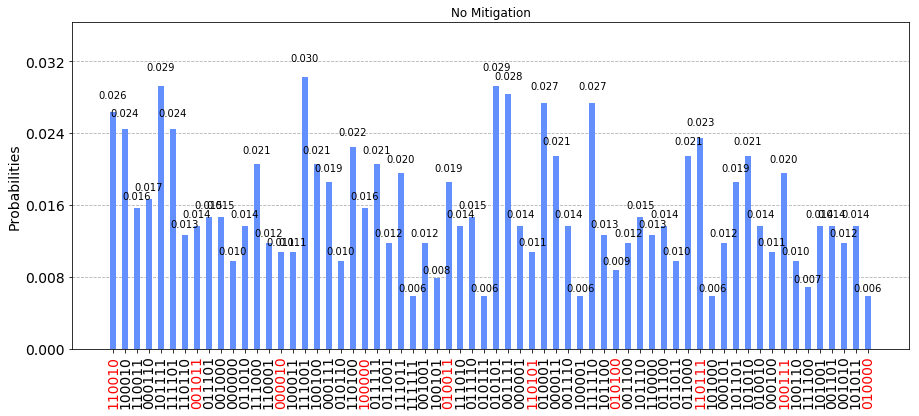

In [39]:
counts = {dec_to_binary_str(i, 6): results.get_counts(0).get(dec_to_binary_str(i, 6), 0) for i in range(2**6)}
fig, ax = plt.subplots(figsize=(15, 6))
#ax.bar(counts_nomit.keys(), [v for v in counts_nomit.values()])
xlabels = list(results.get_counts(0).keys())
plot_histogram(results.get_counts(0), ax=ax, title="No Mitigation")
ax.set_xticklabels(xlabels, rotation=90)
[ax.get_xticklabels()[i].set_color("red") for i in range(64) if i%7 == 0]
print(ax.get_xticklabels())
plt.show()

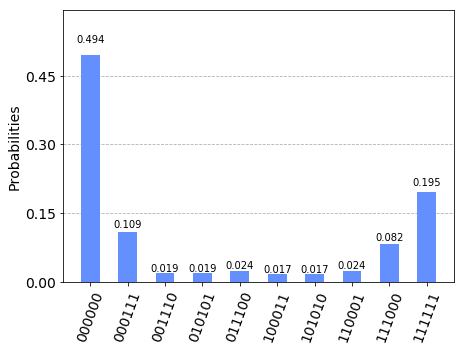

In [32]:
circ = QuantumCircuit(6, 6)
for stp in range(n_steps):
    physical_trotter_circ(circ, list(range(6)), g, alpha, T/n_steps, 1, unitary_sim = False)
    # Add gauge rotations
    ts = np.random.uniform(low=0.0, high=2*np.pi, size=3)
    
    target_ind =list(range(6))
    for i in range(3):
        for s in range(2):
            circ.u1(ts[i] - ts[i-1], target_ind[i+s*3])
            circ.u3(np.pi, 0, np.pi, target_ind[i+s*3])
            circ.u1(-ts[i] + ts[i-1], target_ind[i+s*3])
            circ.u3(np.pi, 0, np.pi, target_ind[i+s*3])
            
circ.measure(list(range(6)), list(range(6)))
result = execute(circ, backend).result()
plot_histogram(result.get_counts())